In [1]:
import numpy as np
import pandas as pd
import mock
from App import App
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Unit Test for App

In [3]:
import contextlib
with contextlib.ExitStack() as patches:
    mock_knn = patches.enter_context(mock.patch('Knn.Knn'))
    mock_genre = patches.enter_context(mock.patch('Genre.Genre'))
    mock_ui = patches.enter_context(mock.patch('UI.UI'))
    mock_su = patches.enter_context(mock.patch('Service.UserService'))
    mock_sm = patches.enter_context(mock.patch('Service.MovieService'))
    mock_sc = patches.enter_context(mock.patch('Service.RecommendService'))
    mock_sr = patches.enter_context(mock.patch('Service.RatingService'))
    mock_us = patches.enter_context(mock.patch('UserService.UserService'))
    mock_ms = patches.enter_context(mock.patch('MovieService.MovieService'))
    mock_cs = patches.enter_context(mock.patch('RecommendService.RecommendService'))
    mock_rs = patches.enter_context(mock.patch('RatingService.RatingService'))
    mock_ud = patches.enter_context(mock.patch('UserData.UserData'))
    mock_md = patches.enter_context(mock.patch('MovieData.MovieData'))
    mock_rd = patches.enter_context(mock.patch('RatingData.RatingData'))
    app = App()
    app.configure()
    # objects are all created only once
    mock_su.assert_called_once()
    mock_sm.assert_called_once()
    mock_sc.assert_called_once()
    mock_sr.assert_called_once()
    mock_us.assert_called_once()
    mock_ms.assert_called_once()
    mock_cs.assert_called_once()
    mock_rs.assert_called_once()
    mock_ud.assert_called_once()
    mock_md.assert_called_once()
    mock_rd.assert_called_once()
    mock_ui.assert_called_once()
    mock_genre.assert_called_once()
    mock_knn.assert_called_once_with('correlation')
    print("All Passed")

All Passed


## Use Case 1: Creates a new app user

In [7]:
# empty app user dataset
df_app_user = pd.DataFrame(columns=['user_id', 'name', 'age', 'gender'])
# instantiate app with custom dataset
app = App()
app.configure(df_app_user = df_app_user)

In [8]:
# create a new user
user = app.bs_user.create_new_user("Tester1", 123, "F")

In [9]:
app.bs_user.find_user(user.get_id())

DEBUG: found app user: 944 Tester1 123 F


## Use Case 2: User logs in as a returning app user

In [12]:
# One app user dataset
df_app_user = pd.DataFrame([[345, "Testing Name", 46, "M"]], columns=['user_id', 'name', 'age', 'gender'])
# instantiate app with custom dataset
app = App()
app.configure(df_app_user = df_app_user)

In [13]:
app.bs_user.find_user(345)

DEBUG: found app user: 345 Testing Name 46 M


## Use Case 3: Logged in user asking a rating estimation for a movie

### Test Case 3-1: User has not enough ratings to perform estimation, being asked to enter ratings for some popular movies

In [2]:
# One app user dataset
df_app_user = pd.DataFrame([[345, "Testing Name", 46, "M"]], columns=['user_id', 'name', 'age', 'gender'])

In [3]:
# 3 movies for test
df_movie = pd.DataFrame([[1, "movie-1", None, None, None, 0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
                        [2, "movie-2", None, None, None, 0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
                        [3, "movie-3", None, None, None, 0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]], 
                        columns = ['movie_id', 'title', 'release_date', 'video_release_date',
                    'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                    'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama',
                    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])

In [4]:
# test rating matrix (user x movie)
df_ratmat = pd.DataFrame([[0, 0, 0, 0,], 
                          [1, 3, 0, 2], 
                          [2, 0, 1, 0], 
                          [3, 0, 0, 0], 
                          [4, 4, 2, 2]],
                         columns = ['user_id', '1', '2', '3',])

In [5]:
# user has no rating
df_app_data = pd.DataFrame(
                    columns=['user_id', 'item_id', 'rating', 'timestamp'])

In [6]:
app = App()
# assume demanded 3 movie ratings
num_of_movie_need_rating = 3
# instantiate app with custom dataset
app.configure(
    num_of_movie_need_rating=num_of_movie_need_rating, 
    df_app_user=df_app_user, 
    df_movie=df_movie, 
    df_ratmat=df_ratmat,
    df_app_data=df_app_data)

In [7]:
# no ratings are returned as expected
app.bs_rating.get_valid_user_ratings(345)

,user_id,item_id,rating,timestamp


In [7]:
# get most watched movies for the user to fill in ratings
app.bs_movie.get_most_watched_movie(345, 5)

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,movie-1,None,None,None,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,movie-2,None,None,None,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,movie-3,None,None,None,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Test Case 3-2: User enters some ratings but not enough, being asked for another set of movies

In [7]:
# add some app user rating, rated 3 for movie 1
app.bs_rating.add_user_rating(345, 1, 3)

adding user rating :  345 1 3


In [8]:
# get most watched movies for the user to fill in ratings again, this time movie-1 is not prompted
app.bs_movie.get_most_watched_movie(345, 5)

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,2,movie-2,None,None,None,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,movie-3,None,None,None,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Test Case 4: User select 'recommend movie rating' function

### Test Case 4-1: It displays movie information by movie title

In [9]:
movie = app.bs_movie.get_movie_by_title("movie-3")
print("id:", movie.get_id(), ", title:", movie.get_title())

id: 3 , title: movie-3


### Test Case 4-2: Movie is not found by movie title

In [10]:
movie = app.bs_movie.get_movie_by_title("movie-4")
print("movie:", movie)

movie: None


### Test Case 4-3: Get Movie rating estimation

In [11]:
app.bs_recommend.recommend_rating(345, 2, 3)

3.613499527564139

## Test Case 5: User select 'recommend movie by genre' function

In [19]:
# 3 movies for test
df_movie_genre = pd.DataFrame([[1, 3.3, "movie-1", "Animation Childrens Comedy"],
                        [1, 2.1, "movie-2", "Action Adult Comedy"],
                        [1, 4.56, "movie-3", "Horror Romance"],], 
                        columns = ['item id', 'rating', 'movie title', 'genre'])

In [20]:
app = App()
# instantiate app with custom dataset
app.configure(
    num_of_movie_need_rating=num_of_movie_need_rating, 
    df_app_user=df_app_user, 
    df_movie=df_movie, 
    df_ratmat=df_ratmat,
    df_app_data=df_app_data,
df_movie_genre=df_movie_genre)

In [21]:
app.bs_recommend.recommend_movie_by_genre(3, 3)

recommended movies by genre:
   movie title                       genre  rating
0     movie-1  Animation Childrens Comedy     3.3
1     movie-2         Action Adult Comedy     2.1


,movie title,genre,rating
0,movie-1,Animation Childrens Comedy,3.3
1,movie-2,Action Adult Comedy,2.1


# Validate rating recommendation function

### Create a set of testing datasets for 4 users and 3 movies.

In [8]:
df_movie = pd.DataFrame([[1, "movie-1", None, None, None, 0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
                        [2, "movie-2", None, None, None, 0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,],
                        [3, "movie-3", None, None, None, 0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]], 
                        columns = ['movie_id', 'title', 'release_date', 'video_release_date',
                    'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation',
                    'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama',
                    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
df_movie

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,movie-1,None,None,None,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,movie-2,None,None,None,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,movie-3,None,None,None,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
# test rating matrix (user x movie)
df_ratmat = pd.DataFrame([[0, 0, 0, 0,], 
                          [1, 3, 0, 2], 
                          [2, 0, 1, 0], 
                          [3, 0, 0, 0], 
                          [4, 4, 2, 2]],
                         columns = ['user_id', '1', '2', '3',])
df_ratmat = df_ratmat.set_index("user_id")
df_ratmat

,1,2,3
user_id,,,
0,0,0,0
1,3,0,2
2,0,1,0
3,0,0,0
4,4,2,2


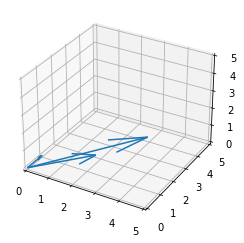

In [85]:
U, V, W = zip(np.array(df_ratmat[1:5].T))
X, Y, Z = zip(np.zeros([3,4], dtype=float))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])
ax.set_zlim([0, 5])
plt.show()

#### By using cosine similarity, user 1(3, 0, 2) is close to user 4 (4, 2, 2) and user 2 (0, 1, 0) is close to user 4 

### Use cosine distance metric for finding closest users at K=1

In [86]:
app = App()
app.configure(knn_sim_metric="cosine",df_movie=df_movie,df_ratmat=df_ratmat)

In [87]:
# estimate rating by user_id = 2, movie_id = 1, K = 1, expected user 4 is close one
app.bs_recommend.recommend_rating(2, 1, 1)

user_id: 2 , movie_id: 1 , n_neighbor: 1
user_with_movie_rating:
          1  2  3
user_id         
1        3  0  2
4        4  2  2
app user ratings: [[0 1 0]]
found knn neighbors (distance, index): (array([[0.59175171]]), array([[1]]))
index: 1 , user_id: 4 , rating: 4 , score: 0.6282386844688339
estimated rating: 4.0


4.0

In [88]:
# estimate rating by user_id = 1, movie_id = 1, K = 1, expected user 4 is close one
app.bs_recommend.recommend_rating(1, 1, 1)

user_id: 1 , movie_id: 1 , n_neighbor: 1
user_with_movie_rating:
          1  2  3
user_id         
4        4  2  2
app user ratings: [[3 0 2]]
found knn neighbors (distance, index): (array([[0.09417837]]), array([[0]]))
index: 0 , user_id: 4 , rating: 4 , score: 0.9139277698815436
estimated rating: 4.0


4.0

In [89]:
# estimate rating by user_id = 4, movie_id = 1, K = 1, expected user 1 is close one
app.bs_recommend.recommend_rating(4, 1, 1)

user_id: 4 , movie_id: 1 , n_neighbor: 1
user_with_movie_rating:
          1  2  3
user_id         
1        3  0  2
app user ratings: [[4 2 2]]
found knn neighbors (distance, index): (array([[0.09417837]]), array([[0]]))
index: 0 , user_id: 1 , rating: 3 , score: 0.9139277698815436
estimated rating: 3.0


3.0

### Test euclidean distance metric at K = 1, user 1(3, 0, 2) is close to user 4 (4, 2, 2) and user 2 (0, 1, 0) is close to user 1 

In [92]:
app = App()
app.configure(knn_sim_metric="euclidean",df_movie=df_movie,df_ratmat=df_ratmat)

In [96]:
# estimate rating by user_id = 2, movie_id = 1, K = 1, expected user 1 is close one
app.bs_recommend.recommend_rating(2, 1, 1)

user_id: 2 , movie_id: 1 , n_neighbor: 1
user_with_movie_rating:
          1  2  3
user_id         
1        3  0  2
4        4  2  2
app user ratings: [[0 1 0]]
found knn neighbors (distance, index): (array([[3.74165739]]), array([[0]]))
index: 0 , user_id: 1 , rating: 3 , score: 0.21089672205953397
estimated rating: 3.0000000000000004


3.0000000000000004

In [97]:
# estimate rating by user_id = 1, movie_id = 1, K = 1, expected user 4 is close one
app.bs_recommend.recommend_rating(1, 1, 1)

user_id: 1 , movie_id: 1 , n_neighbor: 1
user_with_movie_rating:
          1  2  3
user_id         
4        4  2  2
app user ratings: [[3 0 2]]
found knn neighbors (distance, index): (array([[2.23606798]]), array([[0]]))
index: 0 , user_id: 4 , rating: 4 , score: 0.3090169943749474
estimated rating: 4.0


4.0

In [98]:
# estimate rating by user_id = 4, movie_id = 1, K = 1, expected user 1 is close one
app.bs_recommend.recommend_rating(4, 1, 1)

user_id: 4 , movie_id: 1 , n_neighbor: 1
user_with_movie_rating:
          1  2  3
user_id         
1        3  0  2
app user ratings: [[4 2 2]]
found knn neighbors (distance, index): (array([[2.23606798]]), array([[0]]))
index: 0 , user_id: 1 , rating: 3 , score: 0.3090169943749474
estimated rating: 3.0


3.0

### Use cosine distance metric for finding closest users at K=2

In [99]:
app = App()
app.configure(knn_sim_metric="cosine",df_movie=df_movie,df_ratmat=df_ratmat)

In [108]:
# estimate rating by user_id = 2, movie_id = 1, K = 2, expected both are close one
app.bs_recommend.recommend_rating(2, 1, 2)

user_id: 2 , movie_id: 1 , n_neighbor: 2
user_with_movie_rating:
          1  2  3
user_id         
1        3  0  2
4        4  2  2
app user ratings: [[0 1 0]]
found knn neighbors (distance, index): (array([[1.5       , 1.94491118]]), array([[1, 0]]))
index: 1 , user_id: 4 , rating: 4 , score: 0.4
index: 0 , user_id: 1 , rating: 3 , score: 0.33956881482016193
estimated rating: 3.5408556877797315


3.5408556877797315

In [102]:
# estimate rating by user_id = 1, movie_id = 1, K = 2, expected user 4 is close one
app.bs_recommend.recommend_rating(1, 1, 2)

user_id: 1 , movie_id: 1 , n_neighbor: 2
user_with_movie_rating:
          1  2  3
user_id         
4        4  2  2
app user ratings: [[3 0 2]]
found knn neighbors (distance, index): (array([[0.09417837]]), array([[0]]))
index: 0 , user_id: 4 , rating: 4 , score: 0.9139277698815436
estimated rating: 4.0


4.0

#### User 1 doesn't have rating for movie 1, thus skipped in neighbor list

In [103]:
# estimate rating by user_id = 4, movie_id = 1, K = 2, expected user 1 is close one
app.bs_recommend.recommend_rating(4, 1, 2)

user_id: 4 , movie_id: 1 , n_neighbor: 2
user_with_movie_rating:
          1  2  3
user_id         
1        3  0  2
app user ratings: [[4 2 2]]
found knn neighbors (distance, index): (array([[0.09417837]]), array([[0]]))
index: 0 , user_id: 1 , rating: 3 , score: 0.9139277698815436
estimated rating: 3.0


3.0

### Use correlation distance metric for finding closest users at K=2

In [104]:
app = App()
app.configure(knn_sim_metric="correlation",df_movie=df_movie,df_ratmat=df_ratmat)

In [106]:
# estimate rating by user_id = 2, movie_id = 1, K = 2, expected both are close one
app.bs_recommend.recommend_rating(2, 1, 2)

user_id: 2 , movie_id: 1 , n_neighbor: 2
user_with_movie_rating:
          1  2  3
user_id         
1        3  0  2
4        4  2  2
app user ratings: [[0 1 0]]
found knn neighbors (distance, index): (array([[1.5       , 1.94491118]]), array([[1, 0]]))
index: 1 , user_id: 4 , rating: 4 , score: 0.4
index: 0 , user_id: 1 , rating: 3 , score: 0.33956881482016193
estimated rating: 3.5408556877797315


3.5408556877797315

In [109]:
# estimate rating by user_id = 1, movie_id = 1, K = 2, expected user 4 is close one
app.bs_recommend.recommend_rating(1, 1, 2)

user_id: 1 , movie_id: 1 , n_neighbor: 2
user_with_movie_rating:
          1  2  3
user_id         
4        4  2  2
app user ratings: [[3 0 2]]
found knn neighbors (distance, index): (array([[0.24407105]]), array([[0]]))
index: 0 , user_id: 4 , rating: 4 , score: 0.8038126092553827
estimated rating: 4.0


4.0

In [110]:
# estimate rating by user_id = 4, movie_id = 1, K = 2, expected user 1 is close one
app.bs_recommend.recommend_rating(4, 1, 2)

user_id: 4 , movie_id: 1 , n_neighbor: 2
user_with_movie_rating:
          1  2  3
user_id         
1        3  0  2
app user ratings: [[4 2 2]]
found knn neighbors (distance, index): (array([[0.24407105]]), array([[0]]))
index: 0 , user_id: 1 , rating: 3 , score: 0.8038126092553827
estimated rating: 3.0


3.0